In [1]:
# Importing the required libraries

# Configuring Tensorflow
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers.legacy import Adam

import nltk
from nltk.corpus import stopwords
from textblob import Word

/Users/kprakhar27/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Setting the random seed

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kprakhar27/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kprakhar27/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
print(f"Current Working Directory: {os.getcwd()}")

print("Changing the directory to the project root directory...")
os.chdir("/Users/kprakhar27/Documents/NEU/FAI - Project/")

print(f"Current Working Directory: {os.getcwd()}")

DATA_DIR = "data"

Current Working Directory: /Users/kprakhar27/Documents/NEU/FAI - Project/src
Changing the directory to the project root directory...
Current Working Directory: /Users/kprakhar27/Documents/NEU/FAI - Project


## Historical Sensex Price

In [5]:
# path of historical data
HIST_DATA = os.path.join(DATA_DIR, "Sensex_historical_price.csv")
# import data
df = pd.read_csv(HIST_DATA, thousands=',')
# Reverse data in increasing order of Dates
df = df.iloc[::-1]
# Combine Date Columns
cols = ['Day', 'Month', 'Year']
df['Date'] = df[cols].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
# Convert Date to Timestamp
df['Date']= pd.to_datetime(df['Date'])

df.head()

,Day,Month,Year,Open,High,Low,Close,Adj Close,Volume,Date
6575,1,Jul,1997,4263.11,4301.77,4247.66,4300.86,4300.86,NaN,1997-07-01
6574,2,Jul,1997,4302.96,4395.31,4295.40,4333.90,4333.90,NaN,1997-07-02
6573,3,Jul,1997,4335.79,4393.29,4299.97,4323.46,4323.46,NaN,1997-07-03
6572,4,Jul,1997,4332.70,4347.59,4300.58,4323.82,4323.82,NaN,1997-07-04
6571,7,Jul,1997,4326.81,4391.01,4289.49,4291.45,4291.45,NaN,1997-07-07


## Clean Sensex data

In [6]:
# Selecting only the "Date" and "Adj Close" columns from the DataFrame df
data = df[["Date", "Adj Close"]]

# Renaming the "Adj Close" column to "adj_close" for clarity
data = data.rename(columns={"Adj Close": "adj_close"})

# Dropping rows with missing values in the "adj_close" column
data.dropna(subset=['adj_close'], inplace=True)

# Shifting the "adj_close" column down by one row to create a new column "next_close"
data['next_close'] = data['adj_close'].shift(-1)

# Calculating the percentage difference between "next_close" and "adj_close" and storing it in the "difference" column
data['difference'] = ((data["next_close"] - data["adj_close"]) / data["adj_close"])

# Displaying information about the DataFrame, including data types and non-null counts
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6451 entries, 6575 to 0
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        6451 non-null   datetime64[ns]
 1   adj_close   6451 non-null   float64       
 2   next_close  6450 non-null   float64       
 3   difference  6450 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 252.0 KB


In [7]:
data.head()

,Date,adj_close,next_close,difference
6575,1997-07-01,4300.86,4333.90,0.007682
6574,1997-07-02,4333.90,4323.46,-0.002409
6573,1997-07-03,4323.46,4323.82,0.000083
6572,1997-07-04,4323.82,4291.45,-0.007486
6571,1997-07-07,4291.45,4306.39,0.003481


<Axes: >

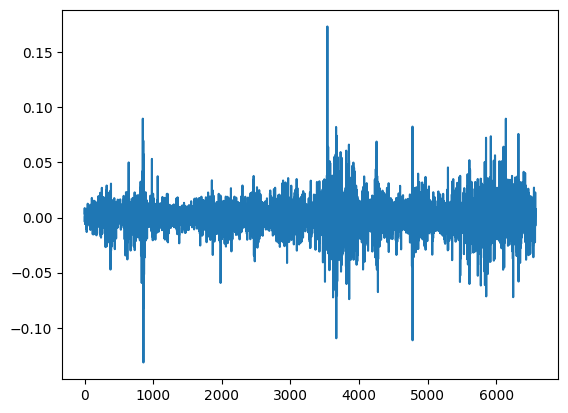

In [8]:
data["difference"].plot()

In [9]:
# Define a custom scaling function named 'custom_scale' that scales values based on a condition
def custom_scale(value):
    # Check if the value is non-negative
    if value >= 0:
        # Scale the value by dividing it by the maximum value in the 'difference' column
        return value / data['difference'].max()
    else:
        # Scale the absolute value of the negative value by dividing it by the minimum value in the 'difference' column
        return -value / data['difference'].min()

# Apply the 'custom_scale' function to the 'difference' column and create a new column named 'sentiment'
data['sentiment'] = data['difference'].apply(custom_scale)

data.head()

,Date,adj_close,next_close,difference,sentiment
6575,1997-07-01,4300.86,4333.90,0.007682,0.044305
6574,1997-07-02,4333.90,4323.46,-0.002409,-0.018315
6573,1997-07-03,4323.46,4323.82,0.000083,0.000480
6572,1997-07-04,4323.82,4291.45,-0.007486,-0.056920
6571,1997-07-07,4291.45,4306.39,0.003481,0.020078


<Axes: >

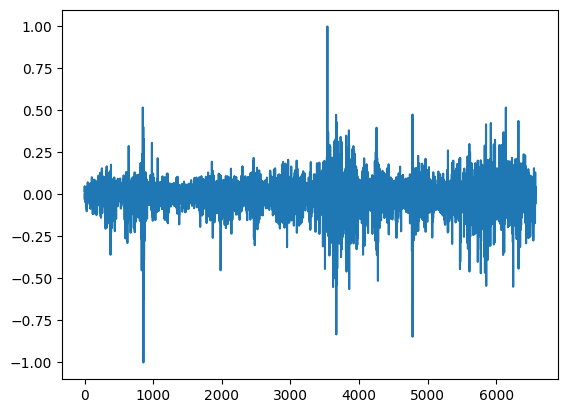

In [10]:
data["sentiment"].plot()

In [11]:
data.head()

,Date,adj_close,next_close,difference,sentiment
6575,1997-07-01,4300.86,4333.90,0.007682,0.044305
6574,1997-07-02,4333.90,4323.46,-0.002409,-0.018315
6573,1997-07-03,4323.46,4323.82,0.000083,0.000480
6572,1997-07-04,4323.82,4291.45,-0.007486,-0.056920
6571,1997-07-07,4291.45,4306.39,0.003481,0.020078


## Historical Indian Financial News Data

In [12]:
# Define the file path for the financial news data
NEWS_DATA = os.path.join(DATA_DIR, "IndianFinancialNews.csv")

# Read the financial news data from the CSV file and set the first column as the index
news = pd.read_csv(NEWS_DATA, index_col=0)

# Reverse the order of rows in the DataFrame to have the most recent data at the top
news = news.iloc[::-1]

# Convert the "Date" column to datetime format for time-based operations
news['Date'] = pd.to_datetime(news['Date'])

# Select only the "Date" and "Description" columns from the DataFrame
news = news[["Date", "Description"]]

# Add a space at the end of each description in the "Description" column
news['Description'] = news['Description'] + " "

# Display the first few rows of the DataFrame to inspect the changes
news.head()

,Date,Description
49999,2003-02-10,Sticky Loans Divide Consortiums
49998,2003-02-10,Rbi Calls Meet To Push Floating Rate Deposits
49997,2003-02-10,"Net Scheduled Inflows Of Rs 1,559.9 Crore"
49996,2003-02-11,Banks Plan To Raise Lending Rates Without Alte...
49995,2003-02-11,Lic Mops Up Government Securities As Prices Cr...


In [13]:
# Group the financial news DataFrame by 'Date' and aggregate the 'Description' column by summing up the descriptions for each date
news = news.groupby(['Date']).agg({'Description': 'sum'}).reset_index()

news.dropna(inplace=True)

In [14]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6068 entries, 0 to 6067
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         6068 non-null   datetime64[ns]
 1   Description  6068 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 94.9+ KB


## Merged Data

In [15]:
# Merge the 'news' DataFrame and the 'data' DataFrame based on the 'Date' column using a left join
merged = pd.merge(news, data, on="Date", how="left")

# Backfill missing values in the 'sentiment' column to fill NaNs with the last valid value
merged["sentiment"] = merged["sentiment"].bfill()

# Select only the specified columns in the desired order ('Date', 'Description', 'sentiment')
merged = merged[['Date', 'Description', 'sentiment']]

# Drop any rows with missing values in the merged DataFrame
merged.dropna(inplace=True)

In [16]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6068 entries, 0 to 6067
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         6068 non-null   datetime64[ns]
 1   Description  6068 non-null   object        
 2   sentiment    6068 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 142.3+ KB


In [17]:
merged.head()

,Date,Description,sentiment
0,2003-02-10,Sticky Loans Divide Consortiums Rbi Calls Meet...,0.008163
1,2003-02-11,Banks Plan To Raise Lending Rates Without Alte...,-0.032543
2,2003-02-12,Sabre Sees Major Role In Banking M & A Space L...,-0.056423
3,2003-02-13,State Bank Plans Home Loan Plr Hsbc Offers Che...,0.105633
4,2003-02-14,Insurance Broking Magnate Draws Mattress Vendo...,0.105633


In [18]:
MERGED_DATA = os.path.join(DATA_DIR, "merged.csv")

merged.to_csv(MERGED_DATA)

## Natural Language Processing

### Using Text Blob
Text Blob is a Python library for Natural Language Processing. Using Text Blob for sentiment analysis is quite simple. It takes text as an input and can return polarity and subjectivity as outputs.

Polarity determines the sentiment of the text. Its values lie in $[-1,1]$ where -1 denotes a highly negative sentiment and 1 denotes a highly positive sentiment.

In [19]:
from textblob import TextBlob

from tqdm import tqdm

tqdm.pandas()

In [20]:
merged['TextBlob'] = merged['Description'].progress_apply(lambda x: TextBlob(str(x)).sentiment.polarity)

100%|█████████████████████████████████████| 6068/6068 [00:03<00:00, 1745.76it/s]


#### Error Metrics for TextBlob

In [21]:
from sklearn.metrics import mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

In [22]:
# Regression metrics (for illustration)
mse = mean_squared_error(merged['sentiment'], merged['TextBlob'])
r2 = r2_score(merged['sentiment'], merged['TextBlob'])
rmse = np.sqrt(mean_squared_error(merged['sentiment'], merged['TextBlob']))

print("\nRegression Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Regression Metrics:
Mean Squared Error: 0.0211
R-squared (R2) Score: -1.3533
Root Mean Squared Error (RMSE): 0.1451


### Using FinBERT

**FinBERT** is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification.

In [23]:
from transformers import pipeline

sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

In [24]:
def get_sentiment_scores(headlines):
    result = sentiment_pipeline(headlines[:500])[0]

    label = result['label']
    score = result['score']

    if label == 'negative':
        score = -1 * score

    return score


merged['FinBERT'] = merged['Description'].progress_apply(lambda x: get_sentiment_scores(str(x)))

100%|███████████████████████████████████████| 6068/6068 [04:57<00:00, 20.38it/s]


#### Error Metrics for TextBlob

In [25]:
# Regression metrics (for illustration)
mse = mean_squared_error(merged['sentiment'], merged['FinBERT'])
r2 = r2_score(merged['sentiment'], merged['FinBERT'])
rmse = np.sqrt(mean_squared_error(merged['sentiment'], merged['FinBERT']))

print("\nRegression Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Regression Metrics:
Mean Squared Error: 0.1623
R-squared (R2) Score: -0.9857
Root Mean Squared Error (RMSE): 0.1274


### Training LSTM Model

In [26]:
# Pre-processing function for cleaning text data
def cleaning(headlines):
    # Get the list of English stop words
    stop_words = stopwords.words('english')

    # Convert text to lowercase
    headlines = ' '.join(x.lower() for x in str(headlines).split())
    
    # Remove the letter 'd'
    headlines = headlines.replace('d', '')
    
    # Remove stop words
    headlines = ' '.join(x for x in str(headlines).split() if x not in stop_words)
    
    # Lemmatization using the WordNetLemmatizer
    headlines = ' '.join([Word(headlines).lemmatize() for x in str(headlines).split()])
    
    return headlines

# Apply the 'cleaning' function to the 'Description' column and create a new column named 'cleaned'
merged['cleaned'] = merged['Description'].apply(cleaning)

In [27]:
# Set the maximum number of words to tokenize and the maximum sequence length for padding
max_words = 5000  # Maximum number of words to tokenize
max_sequence_length = 100  # Maximum sequence length for padding

# Create a tokenizer with a specified maximum number of words and an out-of-vocabulary token
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')

# Fit the tokenizer on the 'cleaned' column of the DataFrame
tokenizer.fit_on_texts(merged['cleaned'])

# Convert the text data to sequences of integers using the tokenizer
X = tokenizer.texts_to_sequences(merged['cleaned'])

# Pad the sequences to ensure uniform length using the specified maximum sequence length
X = pad_sequences(X, maxlen=max_sequence_length, padding='post', truncating='post')

In [28]:
len(tokenizer.word_index)

22350

In [29]:
# Set y labels
y = merged['sentiment'].values

### Custom NLP Model 1

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=100, activation='tanh'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

2023-12-12 18:28:35.152771: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-12 18:28:35.152814: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-12 18:28:35.152818: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-12 18:28:35.153016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 18:28:35.153371: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


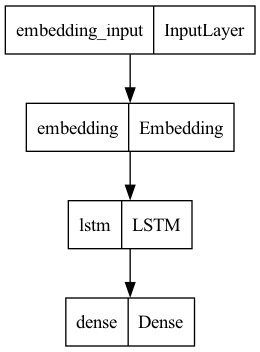

In [31]:
from keras.utils import plot_model

# Plotting the architecture of the model
plot_model(model)

Epoch 1/10


2023-12-12 18:28:37.752853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


137/137 [==============================] - 34s 211ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 2/10
137/137 [==============================] - 16s 114ms/step - loss: 0.0077 - val_loss: 0.0100
Epoch 3/10
137/137 [==============================] - 12s 85ms/step - loss: 0.0051 - val_loss: 0.0117
Epoch 4/10
137/137 [==============================] - 8s 56ms/step - loss: 0.0031 - val_loss: 0.0117
Epoch 5/10
137/137 [==============================] - 8s 56ms/step - loss: 0.0022 - val_loss: 0.0136
Epoch 6/10
137/137 [==============================] - 7s 54ms/step - loss: 0.0015 - val_loss: 0.0152
Epoch 7/10
137/137 [==============================] - 7s 51ms/step - loss: 0.0010 - val_loss: 0.0139
Epoch 8/10
137/137 [==============================] - 6s 44ms/step - loss: 7.2865e-04 - val_loss: 0.0143
Epoch 9/10
137/137 [==============================] - 5s 36ms/step - loss: 5.8324e-04 - val_loss: 0.0142
Epoch 10/10
137/137 [==============================] - 6s 45ms/step - loss: 5.4418e-04 - 

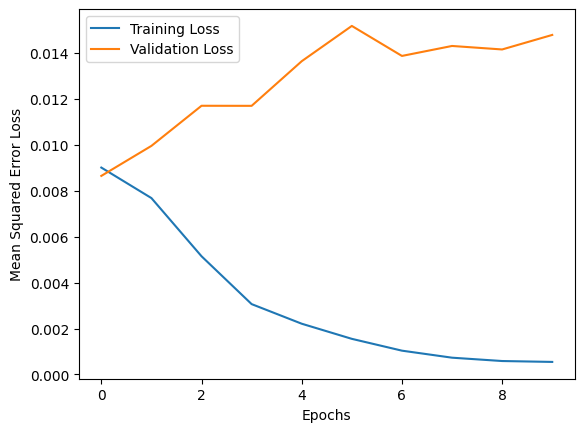

In [32]:
# Train the model and capture the history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Plot the training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

In [33]:
predictions = model.predict(X_test)

38/38 [==============================] - 2s 18ms/step


#### Error Metrics for Custom NLP 1

In [34]:
# Regression metrics (for illustration)
mse = mean_squared_error(merged['sentiment'].values[-1214:], predictions)
r2 = r2_score(merged['sentiment'].values[-1214:], predictions)
rmse = np.sqrt(mean_squared_error(merged['sentiment'].values[-1214:], predictions))

print("\nRegression Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Regression Metrics:
Mean Squared Error: 0.0119
R-squared (R2) Score: -0.8818
Root Mean Squared Error (RMSE): 0.1092


In [35]:
# Save Model

model.save("custom_nlp1.keras")

### Custom NLP Model 2

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=100, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='tanh'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


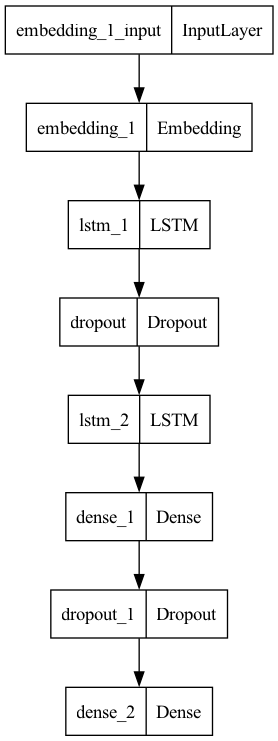

In [37]:
# Plotting the architecture of the model

plot_model(model)

In [38]:
# Train the model and capture the history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
137/137 [==============================] - 38s 208ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 2/10
137/137 [==============================] - 15s 108ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 3/10
137/137 [==============================] - 11s 81ms/step - loss: 0.0079 - val_loss: 0.0118
Epoch 4/10
137/137 [==============================] - 8s 58ms/step - loss: 0.0077 - val_loss: 0.0113
Epoch 5/10
137/137 [==============================] - 8s 58ms/step - loss: 0.0062 - val_loss: 0.0109
Epoch 6/10
137/137 [==============================] - 8s 56ms/step - loss: 0.0053 - val_loss: 0.0115
Epoch 7/10
137/137 [==============================] - 8s 56ms/step - loss: 0.0045 - val_loss: 0.0114
Epoch 8/10
137/137 [==============================] - 7s 50ms/step - loss: 0.0041 - val_loss: 0.0121
Epoch 9/10
137/137 [==============================] - 6s 44ms/step - loss: 0.0033 - val_loss: 0.0129
Epoch 10/10
137/137 [==============================] - 7s 52ms/step - loss: 0.0024 - v

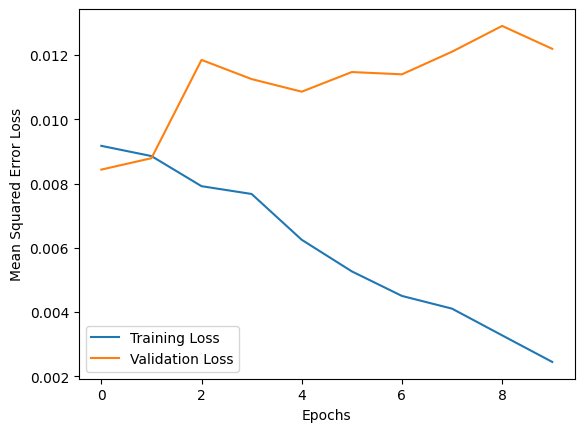

In [39]:
# Plot the training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

In [40]:
predictions = model.predict(X_test)

38/38 [==============================] - 3s 30ms/step


#### Custom NLP Model 2

In [41]:
# Regression metrics (for illustration)
mse = mean_squared_error(merged['sentiment'].values[-1214:], predictions)
r2 = r2_score(merged['sentiment'].values[-1214:], predictions)
rmse = np.sqrt(mean_squared_error(merged['sentiment'].values[-1214:], predictions))

print("\nRegression Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Regression Metrics:
Mean Squared Error: 0.0100
R-squared (R2) Score: -0.5813
Root Mean Squared Error (RMSE): 0.1001


In [42]:
# Save Model

model.save("custom_nlp2.keras")

# END

# Predict For New Data

In [43]:
DATA_URL = os.path.join(DATA_DIR, "fai_project_data.csv")

df = pd.read_csv(DATA_URL)

df.dropna(inplace=True)

required_cols = ["Date", "Close", "Open", "High", "Low", "Volume",
                 "Dividends", "Stock Splits", "Ticker", "Headlines"]
df = df[required_cols]

df['Date']= pd.to_datetime(df['Date'])

In [44]:
from abc import ABC, abstractmethod

from typing import List

class SentimentAnalyzer(ABC):

    @abstractmethod
    def get_sentiment_scores(self, headlines: List[str]) -> float:
        pass

In [45]:
import tqdm

In [46]:
df['cleaned'] = df['Headlines'].apply(cleaning)
tokenizer.fit_on_texts(df['cleaned'])

X = tokenizer.texts_to_sequences(df['cleaned'])
X = pad_sequences(X, maxlen=max_sequence_length, padding='post', truncating='post')

In [47]:
df['sentiment'] = model.predict(X)

75/75 [==============================] - 1s 13ms/step


In [48]:
df.Ticker.unique()

train_tickers = ["AAPL", "ABNB", "COIN", "META", "MRNA", "NVDA", "PLTR", "AMZN", "TSLA"]

test_tickers = ["GOOG"]

train_df = df[df["Ticker"].isin(train_tickers)]
test_df = df[df["Ticker"].isin(test_tickers)]

In [49]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from sklearn.metrics import mean_squared_error

from typing import Optional


class MultivariateTimeSeriesModel(object):

    def __init__(self, stock_data: pd.DataFrame, model: str = "GRU",
                 is_custom_sentiment_analyzer: bool = False,
                 sentiment_analyzer: Optional[SentimentAnalyzer] = None):

        self.stock_data = stock_data
        self.sentiment_analyzer = sentiment_analyzer
        self.is_custom_sentiment_analyzer = is_custom_sentiment_analyzer

        self.model = model


    def data_preprocessing(self, df):
        cols = ["Date", "Open", "High", "Low", "Close"]

        # if self.sentiment_analyzer:
        #     if not self.is_custom_sentiment_analyzer:
        #         df["sentiment"] = df["Headlines"].progress_apply(self.sentiment_analyzer.get_sentiment_scores)
        #     cols.append("sentiment")

        if self.sentiment_analyzer:
            # df["sentiment"] = df["Headlines"].progress_apply(self.sentiment_analyzer.get_sentiment_scores)
            cols.append("sentiment")

        stock_data = df[cols]

        # convert the Date column to DateTime from Object type
        set_dates = pd.to_datetime(stock_data['Date'])
        set_dates.head()

        # extract the required features (in this we are omiting the volume from feature list)

        if self.sentiment_analyzer:
            columns = list(stock_data.columns[1:6])
        else:
            columns = list(stock_data.columns[1:5])

        processed_df = stock_data[columns].astype(float)
        processed_df.head()

        # Normalize the data using the Standard scaler
        self.standard_scaler = StandardScaler()
        self.standard_scaler = self.standard_scaler.fit(processed_df)
        scaled_training_df = self.standard_scaler.transform(processed_df)

        X = []
        Y = []

        future_no_of_days = 1 # num of days to predict the future values
        past_no_of_days = 14 # number of days on which the prediction is computed

        for i in range(past_no_of_days, len(scaled_training_df) - future_no_of_days+1):
            X.append(scaled_training_df[i - past_no_of_days:i, 0:processed_df.shape[1]])
            Y.append(scaled_training_df[i + future_no_of_days - 1:i + future_no_of_days, 0])

        X, Y = np.array(X), np.array(Y)

        self.X = X

        print('X shape: {}'.format(X.shape))
        print('Y shape: {}'.format(Y.shape))

        return X, Y, processed_df


    @staticmethod
    def get_GRU_model(X_shape_1, X_shape_2, Y_shape):
        model = Sequential()
        model.add(GRU(64, activation='relu', input_shape=(X_shape_1, X_shape_2), return_sequences=True))
        model.add(GRU(32, activation='relu', return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(Y_shape))

        return model


    @staticmethod
    def get_LSTM_model(X_shape_1, X_shape_2, Y_shape):
        model = Sequential()
        model.add(LSTM(64, input_shape=(X_shape_1, X_shape_2), return_sequences=True))
        model.add(LSTM(32, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(Y_shape))

        return model

    @staticmethod
    def get_RNN_model(X_shape_1, X_shape_2, Y_shape):
        model = Sequential()
        model.add(RNN(64, input_shape=(X_shape_1, X_shape_2), return_sequences=True))
        model.add(RNN(32, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(Y_shape))

        return model


    def get_model(self, trainX, trainY):
        X_shape_1 = trainX.shape[1]
        X_shape_2 = trainX.shape[2]
        Y_shape = trainY.shape[1]

        if self.model == "GRU":
            model = self.get_GRU_model(X_shape_1, X_shape_2, Y_shape)
        elif self.model == "LSTM":
            model = self.get_LSTM_model(X_shape_1, X_shape_2, Y_shape)
        else:
            model = self.get_RNN_model(X_shape_1, X_shape_2, Y_shape)
        model.summary()

        return model

    def compile_model(self, optimizer, loss):
        self.model.compile(optimizer=optimizer, loss=loss)

    def train_model(self):
        trainX, trainY, df_train = self.data_preprocessing(self.stock_data)

        self.model = self.get_model(trainX, trainY)
        self.compile_model(optimizer="adam", loss="mse")

        # fit the model
        history = self.model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

        plt.figure(figsize=(12, 8))
        plt.plot(history.history['loss'], label='Training loss')
        plt.plot(history.history['val_loss'], label='Validation loss')
        plt.legend()
        plt.show()


    def run_inference(self, test_df):
        us_business_days = CustomBusinessDay(calendar=USFederalHolidayCalendar())

        n_past = 90
        n_days_for_prediction=90  #let us predict past 15 days

        # convert the Date column to DateTime from Object type
        test_set_dates = pd.to_datetime(test_df['Date'])
        test_set_dates.head()

        predict_period_dates = pd.date_range(
            list(test_set_dates)[-n_past], periods=n_days_for_prediction,
            freq=us_business_days
        ).tolist() # instead of us_business_days we can give '1d' etc.

        testX, testY, df_test = self.data_preprocessing(test_df)

        #Make prediction
        prediction = self.model.predict(testX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

        # predict the future price
        prediction_copies = np.repeat(prediction, df_test.shape[1], axis=-1)
        y_pred_future = self.standard_scaler.inverse_transform(prediction_copies)[:,0]

        # Convert timestamp to date
        forecast_dates = []
        for time_i in predict_period_dates:
            forecast_dates.append(time_i.date())

        df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
        df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

        original = test_df[['Date', 'Close']]
        original['Date']=pd.to_datetime(original['Date'])
        original = original.loc[original['Date'] >= df_forecast.Date.min()] # selecting the data only from 2022 just for our convinence

        mse = mean_squared_error(original["Close"], df_forecast["Close"])
        print(f"Mean Squared Error: {mse}")

        return original, df_forecast

In [50]:
mv_ts_model = MultivariateTimeSeriesModel(train_df, model="GRU", sentiment_analyzer=True)

X shape: (2145, 14, 5)
Y shape: (2145, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 64)            13632     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23073 (90.13 KB)
Trainable params: 23073 (90.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 65s 480ms/step - loss: 0.1910 - val_loss: 0.0143
Epoch

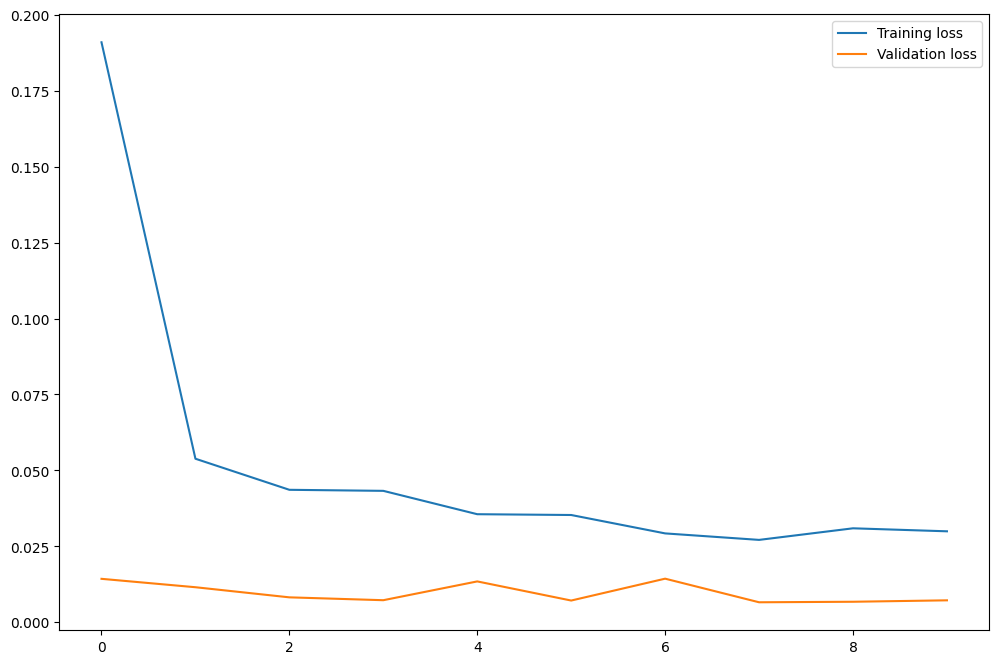

In [51]:
mv_ts_model.train_model()

In [52]:
y_true, y_pred = mv_ts_model.run_inference(test_df)

X shape: (227, 14, 5)
Y shape: (227, 1)
3/3 [==============================] - 4s 869ms/step
Mean Squared Error: 9.13274500208661


/var/folders/h6/k8vv50fn5sl3snld_mq4dwf00000gn/T/ipykernel_47921/354028145.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


X shape: (2145, 14, 4)
Y shape: (2145, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 14, 64)            13440     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22881 (89.38 KB)
Trainable params: 22881 (89.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 61s 461ms/step - loss: 0.1746 - val_loss: 0.0091
Epoch

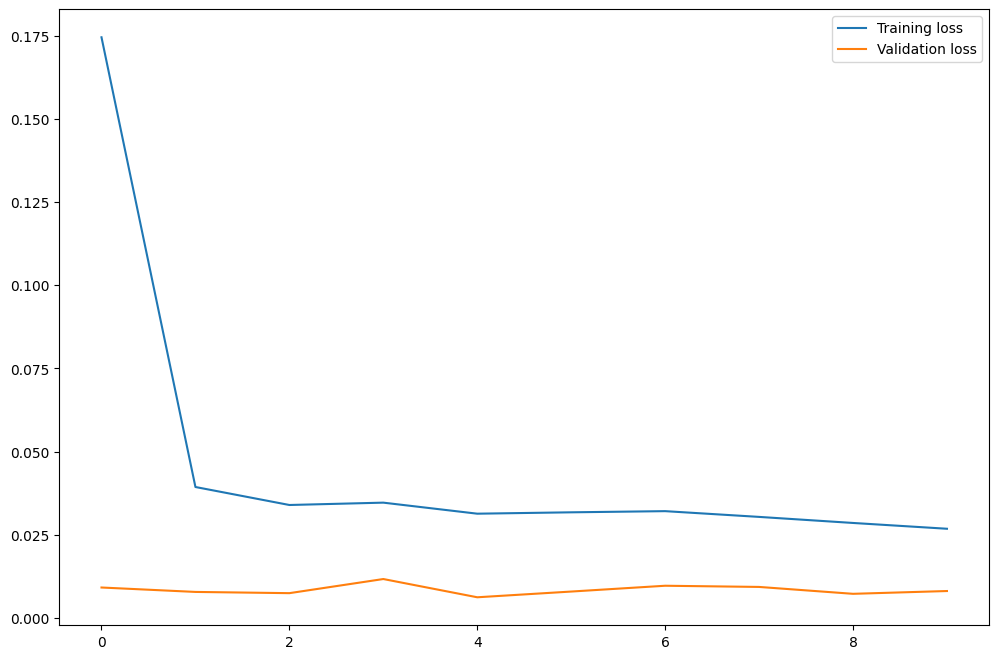

In [53]:
mv_ts_model_ws = MultivariateTimeSeriesModel(train_df, model="GRU")

mv_ts_model_ws.train_model()

In [54]:
y_true_without_sent, y_pred_without_sent = mv_ts_model_ws.run_inference(test_df)

X shape: (227, 14, 4)
Y shape: (227, 1)
3/3 [==============================] - 3s 797ms/step
Mean Squared Error: 10.51592470038708


/var/folders/h6/k8vv50fn5sl3snld_mq4dwf00000gn/T/ipykernel_47921/354028145.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


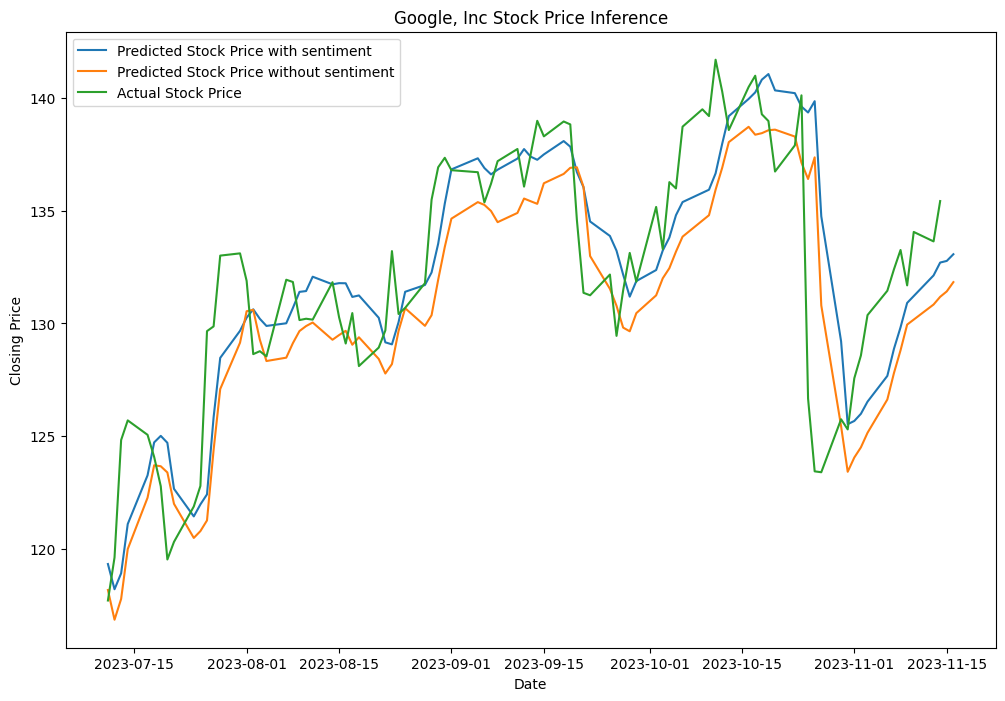

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(12,8))

sns.lineplot(data=y_pred, x='Date', y='Close', label="Predicted Stock Price with sentiment")
sns.lineplot(data=y_pred_without_sent, x='Date', y='Close', label="Predicted Stock Price without sentiment")
sns.lineplot(data=y_true, x='Date', y='Close', label="Actual Stock Price")

plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Google, Inc Stock Price Inference")

plt.show()

### Error Metrics with Sentiment

In [58]:
# Regression metrics (for illustration)
mse = mean_squared_error(y_true['Close'], y_pred['Close'])
r2 = r2_score(y_true['Close'], y_pred['Close'])
rmse = np.sqrt(mean_squared_error(y_true['Close'], y_pred['Close']))

print("\nRegression Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Regression Metrics:
Mean Squared Error: 8.0462
R-squared (R2) Score: 0.7428
Root Mean Squared Error (RMSE): 2.8366


### Error Metrics without Sentiment

In [59]:
# Regression metrics (for illustration)
mse = mean_squared_error(y_true['Close'], y_pred_without_sent['Close'])
r2 = r2_score(y_true['Close'], y_pred_without_sent['Close'])
rmse = np.sqrt(mean_squared_error(y_true['Close'], y_pred_without_sent['Close']))

print("\nRegression Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Regression Metrics:
Mean Squared Error: 10.5159
R-squared (R2) Score: 0.6586
Root Mean Squared Error (RMSE): 3.2428


# END